# 4. Improving and understanding algorithm performance.

Having built a basic machine learning pipeline, one wants to improve performance to get the best results, and also understand the results of the trained algorithm.

## Overview 

### Prerequisites
Completed the first 3 notebooks in this series.

### Learning Outcomes 
* Understand how to improve results through hyperparameter tuning
* Understand basic approaches to improving training data through resampling approaches
* Understand basic explainability and interpretability methods

## Tutorial - Improving ML performance

So far in this series of notebooks, we have started by exploring a dataset we want to use with machine learning to tackle a particular problem, so that we understand the requirements and challenges of working with particular datasets. We have then made use of that knowledge to build a machine learning pipeline to tackle the problem. As a complement to the first notebook which seeks to understand the data, the third notebook looks at some of the details of how the algorithms work to help make appropriate choices for the components and hyperparameters of our machine learning pipeline. In this last notebook we will look at some techniques for making use of the knowledge of how the machine learning pipeline fits together to improve the performance of that pipeline for our problem of interest. We will look at these areas:
* cross-validation
* hyperparameter tuning
* resampling data to tackle the imbalanced class problem
* machine learning interpretability and explainability


### Best Practices
* Data - How can my training data be improved through augmentation, filtering, resampling, extension etc. to improve the results of the ML algorithm?
* Ethics - Can positive impacts be extended or negative ones reduced through correct use of ML algorithms e.g. using the best hyperparameters?
* ML Pitfalls - Could my results be spuriously good or bad through random elements in the pipeline e.g. the train/validate/test split and could this be made more robust through use of appropriate techniques e.g. cross-validation

(Please see [Met Office Best Practice Summary document](https://metoffice.sharepoint.com/:w:/r/sites/MetOfficeDataScienceCommunity/Shared%20Documents/MLAG/project_evaluation_review/MachineLearningBestPracticesAndValues_v1_0.docx?d=wae2554217d0342f2a9c8cf8906bfbe38&csf=1&web=1&e=ja7rLn) on Data Science Community site (internal only) for more information and further reading.)

### What is ultimate end goal for improving performance?

It's important to know that the point of our modelling is to be able to model the whole population of samples we can encounter in our problem. There is no value on a model trained on high quality data made 20 years ago, if it doesn't reflect the data of today where the model is going to be applied.

Keeping this in mind as we explore a machine learning problem can be particularly helpful when improving performance: Are my results sensitive to small changes to the experiment setup? What decisions can I make to improve the longevity of my model / make the results more robust? Can I attempt to explain why a change in my experiment setup produces better results on independent data than another?

### Importance of randomness in sampling data

Random sampling is important for machine learning because a representative sample of your data will help toward modeling on independent data. Particularly to help to ensure that your model is not biased towards any particular group of data points / categories for classification, or learns spurious patterns in data. To give an example for either: When modelling extremes you ideally want to capture an extreme event in every sample that you feed to the model - feeding an all "No event occurred" batch to your model might make negative progress on your goals, similarly if data is not randomized you may encounter a decreasing number of extremes as you feed data to the model which will be particularly destructive in cases where your model is optimized to use weight momentum as your momentum will pick up toward the same undesirable "no event occurred" outcome. In our presented case below, while random tree classifiers use the entire training data to make algorithm decisions on, the problem can still be contextualized through an example where data split between train and test is not randomized, seasonal differences may be a factor in the problem and so the training data may not fully represent the whole population of our problem.


### Cross-validation

Before we train our machine learning algorithm, we split our data into train and test subsets so we can evaluate the performance of the algorithm with data that has not been used to train the algorithm. There is an assumption that the particular split doesn't matter, but this is not always the case, especially where we are not familiar with the dataset that we are using and are less able to evaluate whether a split is suitable or not. What can happen is that a particular split may result in especially good or especially bad results, and generalise poorly to the test and validation sets if rare cases are not present in the training set. One way to get around this is to try multiple different splits and check whether results differ greatly between different splits. This is called cross validation. The way this is done is that after separating out your test set, the remaining data is then split again into train and validate sets. Typically this is done by dividing the data into n *folds* (by whatever means was used for splitting e.g. random, divide by time etc.). The you produced n different train/validate splits, each each using the members of one fold as the validation set and the rest as the training set. K-fold (or n) cross validation is pictured below

![https://towardsdatascience.com/cross-validation-k-fold-vs-monte-carlo-e54df2fc179b](https://miro.medium.com/v2/resize:fit:1200/1*AAwIlHM8TpAVe4l2FihNUQ.png)

### Hyperparameter tuning

As we were setting up our machine learning  pipeline in notebook 2, in the step where were initialising and setting up the ML algorithm before training, we had to set a number of *hyperparameters* for each algorithm. For example we had to set the maximum depth for a decision tree, the number of estimators (i.e. the number of decision trees) in the random forest, and the number of layers and nodes in each layer for a neural network. These were just set to a particular value that are known to be reasonable for that problem. In general when we start a new problem, we can't be so sure we know what is a reasonable value for those hyperparameters.One may have some intuition to guide the choice based on similarity to other problems, but in general one needs to tweak these and do some trial and error experimentation find the values that give the best performance for a particular problem. This process is known as *hyperparameter tuning*. Each run with a different set of hyperparameters is called a *trial*.

In general there is no good systematic way to determine the best hyperparameters. Typically, one needs to train the algorithm a lot of times with different hyperparameters to find the best combination for your problem. Unfortunately the results tend to be quite non-linear, limiting the ability to perform a systematic iterative optimisation. The two most comment methods are
* *grid search* - Grid a grid of regularly space value in the hyperparameter space, train an algorithm with each of the combinations on the grid and select the combination that gives the best results.
* *random search* - Specify a distribution for each of the hyperparameters, get n random samples from the distributions, train an algorithm with each and select the hyperparameter combination that gives the best result.

There are other methods that try to be smarter about selecting based on previous results, and also more exotic method like genetic algorithms. For most problems grid or random search is sufficient. Grid is more comprehensive but costly, so random is often used.

The process of training an algorithm many times is of course very costly, but also very easy to run multiple trials in parallel. See the notes at the bottom of the notebook for more information about tools to help scale up hyperparameter tuning.

### Key Terms
* cross validation - Re-running a machine learning experiment across different splits of test and training data to verify performance results
* hyperparameter tuning - Running multiple machine learning experiments with different experiment setups in an attempt to find an optimal experiment setup

## Exercise - Hyperparameter tuning


In [1]:
import pathlib
import os
import functools
import math
import datetime

In [2]:
import pandas
import numpy

In [3]:
import matplotlib
import matplotlib.pyplot
%matplotlib inline

In [4]:
import sklearn
import sklearn.tree
import sklearn.preprocessing
import sklearn.ensemble

In [5]:
try:
    falklands_data_dir = os.environ['OPMET_ROTORS_DATA_ROOT']
except KeyError:
    falklands_data_dir = '/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge'
falklands_data_dir = pathlib.Path(falklands_data_dir) /  'Rotors'

In [6]:
falklands_data_fname = 'new_training.csv'
falklands_data_path = falklands_data_dir / falklands_data_fname
falklands_df = pandas.read_csv(falklands_data_path)

In [7]:
temp_feature_names = [f'air_temp_{i1}' for i1 in range(1,23)]
humidity_feature_names = [f'sh_{i1}' for i1 in range(1,23)]
wind_direction_feature_names = [f'winddir_{i1}' for i1 in range(1,23)]
wind_speed_feature_names = [f'windspd_{i1}' for i1 in range(1,23)]
target_feature_name = 'rotors_present'


In [8]:
falklands_df = falklands_df.rename({'Rotors 1 is true': target_feature_name},axis=1)
falklands_df.loc[falklands_df[falklands_df[target_feature_name].isna()].index, target_feature_name] = 0
falklands_df['DTG'] = pandas.to_datetime(falklands_df['DTG'])
falklands_df = falklands_df.drop_duplicates(subset=['DTG'])
falklands_df = falklands_df[~falklands_df['DTG'].isnull()]
falklands_df = falklands_df[(falklands_df['wind_speed_obs'] >= 0.0) &
                            (falklands_df['air_temp_obs'] >= 0.0) &
                            (falklands_df['wind_direction_obs'] >= 0.0) &
                            (falklands_df['dewpoint_obs'] >= 0.0) 
                           ]
falklands_df = falklands_df.drop_duplicates(subset='DTG')
falklands_df[target_feature_name]  = falklands_df[target_feature_name] .astype(bool)
falklands_df['time'] = pandas.to_datetime(falklands_df['DTG'])

In [9]:
def get_v_wind(wind_dir_name, wind_speed_name, row1):
    return math.cos(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

def get_u_wind(wind_dir_name, wind_speed_name, row1):
    return math.sin(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

In [10]:
%%time
u_feature_template = 'u_wind_{level_ix}'
v_feature_template = 'v_wind_{level_ix}'
u_wind_feature_names = []
v_wind_features_names = []
for wsn1, wdn1 in zip(wind_speed_feature_names, wind_direction_feature_names):
    level_ix = int( wsn1.split('_')[1])
    u_feature = u_feature_template.format(level_ix=level_ix)
    u_wind_feature_names += [u_feature]
    falklands_df[u_feature] = falklands_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
    v_feature = v_feature_template.format(level_ix=level_ix)
    v_wind_features_names += [v_feature]
    falklands_df[v_feature] = falklands_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

CPU times: user 17.5 s, sys: 1.99 s, total: 19.5 s
Wall time: 19.5 s


In [11]:
rotors_train_df = falklands_df[falklands_df['time'] < datetime.datetime(2020,1,1,0,0)]
rotors_test_df = falklands_df[falklands_df['time'] > datetime.datetime(2020,1,1,0,0)]

In [12]:
def preproc_input(data_subset, pp_dict):
    return numpy.concatenate([scaler1.transform(data_subset[[if1]]) for if1,scaler1 in pp_dict.items()],axis=1)

def preproc_target(data_subset, enc1):
     return enc1.transform(data_subset[[target_feature_name]])


In [13]:
input_feature_names = temp_feature_names + humidity_feature_names + u_wind_feature_names + v_wind_features_names
preproc_dict = {}
for if1 in input_feature_names:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(rotors_train_df[[if1]])
    preproc_dict[if1] = scaler1
    
target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(rotors_train_df[[target_feature_name]])

/data/users/hsouth/conda-envs/ml-weather-tutorial-skl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LabelEncoder()

In [14]:
X_train_rotors = preproc_input(rotors_train_df, preproc_dict)
y_train_rotors = preproc_target(rotors_train_df, target_encoder)

/data/users/hsouth/conda-envs/ml-weather-tutorial-skl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [15]:
X_test_rotors = preproc_input(rotors_test_df, preproc_dict)
y_test_rotors = preproc_target(rotors_test_df, target_encoder)

/data/users/hsouth/conda-envs/ml-weather-tutorial-skl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [16]:
sklearn.tree.DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [17]:
clf_opts = {'max_depth':[5,10,15,20], 
            'min_samples_leaf': [1,2,5],
            'min_samples_split': [4,10,20],
            # 'ccp_alpha': [0.0, 0.01, 0.1],
           }


Here we come to the part that is different. We will do hyperparameter tuning and cross-validation to robustly find the best hyper parameters for this problem. We will do multiple trials with each combination of hyperparameters, and for each combination we will do a cross validation. The steps for setting up our hyperparametr tuning with cross validation are as follows:
* First we create an instance of the classifier for which we want to tune the hyperparameters.
* Then we instantiate an object to handle the cross-validation. This will split the data into folds. This has 2 parameters:
  * `n_splits` - The number of folds.
  * `shuffle` - whether to randomly mix up the data before dividing into folds. If this is false, then the data will be split in its current order.
* Then we create an object to do a grid search hyperparameter tuning. We pass three items:
 * `estimator` - The classifier to tune. This currently has default hyperparameter values, which will be set differently for each trial.
 * `param_grid` - The grid of hyperparameter value to try. The values for each hyperparameter value is specified separately as a list, and all possible combination are tried. So if we specify n options for hyperparameter 1, and m for hyperparameter 2, there will be `n*m` trials.
 * `cv` - The cross validation handler which we created. For each trial we will do a separate cross-validation.

In [18]:
%%time
clf1 = sklearn.tree.DecisionTreeClassifier()
cv1 = sklearn.model_selection.KFold(n_splits=5, shuffle=True)
hpt_grid = sklearn.model_selection.GridSearchCV(estimator=clf1, 
                                                param_grid=clf_opts,
                                                cv=cv1,
                                               )
res1 = hpt_grid.fit(X_train_rotors, y_train_rotors)

CPU times: user 2min 42s, sys: 15.5 ms, total: 2min 42s
Wall time: 2min 42s


In [19]:
hpt_grid.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=20)

In [20]:
sklearn.metrics.precision_recall_fscore_support(
    y_test_rotors, 
    hpt_grid.best_estimator_.predict(X_test_rotors)
)

(array([0.95570055, 0.        ]),
 array([0.9996408, 0.       ]),
 array([0.97717697, 0.        ]),
 array([2784,  129]))

In [21]:
import scipy.stats

Here we demonstrate the other common way of doing hyperparameter tuning, random search. Instead of specifying a list of choices for each hyperparameter, we specify a distribution to sample. The algorithm will sample each distribution for each trial. We specify how many trials to run with the argument `n_iter`. Here are using hyperparameters with integer values so we are just randomly selecting with equal chance. Other hyperparameters have real values. We may want to use different distributions for these, such as uniform or normal distributions, or more specific distributions if we know more about what sot of values a hyperparameter should take on. It easy to select any distribution that SciPy makes available.

In [22]:
%%time
hpt_random = sklearn.model_selection.RandomizedSearchCV(estimator=sklearn.tree.DecisionTreeClassifier(),
                                                        param_distributions={
                                                            'max_depth': scipy.stats.randint(5,10), 
                                                            'min_samples_leaf': scipy.stats.randint(1,7),
                                                            'min_samples_split': scipy.stats.randint(4,20),
                                                        },
                                                        cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True),
                                                        n_iter=20,
                                                     )
res1 = hpt_random.fit(X_train_rotors, y_train_rotors)  

CPU times: user 1min 1s, sys: 8.01 ms, total: 1min 1s
Wall time: 1min 1s


Once we have done the tuning, we can then select the combination of values that results in the best estimator to use from now on for our problem. 

In [23]:
hpt_random.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_leaf=6, min_samples_split=13)

In [24]:
hpt_random.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 6,
 'min_samples_split': 13,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [25]:
sklearn.metrics.precision_recall_fscore_support(
    y_test_rotors, 
    hpt_random.best_estimator_.predict(X_test_rotors)
)

(array([0.95568533, 0.        ]),
 array([0.99928161, 0.        ]),
 array([0.97699737, 0.        ]),
 array([2784,  129]))

Depending on what is most important for our problem, we may want to use different metrics to select the best classifier. Here we demonstrate using balanced accuracy versus recall, which may result in a different choice of hyperparameters.

In [26]:
hpt_random_recall = sklearn.model_selection.RandomizedSearchCV(estimator=sklearn.tree.DecisionTreeClassifier(),
                                                        param_distributions={
                                                            'max_depth': scipy.stats.randint(5,10), 
                                                            'min_samples_leaf': scipy.stats.randint(1,7),
                                                            'min_samples_split': scipy.stats.randint(4,20),
                                                        },
                                                        cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True),
                                                        n_iter=20,
                                                        scoring='recall',
                                                     )
res1 = hpt_random_recall.fit(X_train_rotors, y_train_rotors) 

In [27]:
hpt_random_recall.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [28]:
sklearn.metrics.precision_recall_fscore_support(
    y_test_rotors, 
    hpt_random_recall.best_estimator_.predict(X_test_rotors)
)

(array([0.95936089, 0.35294118]),
 array([0.9920977 , 0.09302326]),
 array([0.97545471, 0.14723926]),
 array([2784,  129]))

In [29]:
hpt_random_ba = sklearn.model_selection.RandomizedSearchCV(estimator=sklearn.tree.DecisionTreeClassifier(),
                                                        param_distributions={
                                                            'max_depth': scipy.stats.randint(5,10), 
                                                            'min_samples_leaf': scipy.stats.randint(1,7),
                                                            'min_samples_split': scipy.stats.randint(4,20),
                                                        },
                                                        cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True),
                                                        n_iter=20,
                                                        scoring='balanced_accuracy',
                                                     )
res1 = hpt_random_ba.fit(X_train_rotors, y_train_rotors) 

In [30]:
hpt_random_ba.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [31]:
sklearn.metrics.precision_recall_fscore_support(
    y_test_rotors, 
    hpt_random_ba.best_estimator_.predict(X_test_rotors)
)

(array([0.95870923, 0.32258065]),
 array([0.9924569 , 0.07751938]),
 array([0.97529121, 0.125     ]),
 array([2784,  129]))

## Making the most of the data

In general, one of the best way to improve the performance of your machine learning algorithm is to improve the quality of your training data. You can do this by
* gathering more data,, especially for examples or classes that are poorly represented
* removing bad or unrepresentative data
* add features that improve descriptive power of your feature vector

All of these steps can be expensive, so sometime we just need to do as much as we can with the data that we have. In particular fr the first problem of under represented classes known as the class imbalance problem, we can resample the data to create a dataset that appears balanced. Although this might seem like it doesn't achieve anything, it can be very helpful. Usually this is a combination of the following tasks:
* undersampling - take a subset of classes that are most common or over represented
* oversampling - taking repeat samples of underrepresented classes
* synthetic samples - If you know enough about the data that you can create a distribution from which to create synthetic samples, this another option for oversampling.

The state of the art for resampling uses a combination of these, such as  Synthetic Minority Oversampling Technique (SMOTE).

Further reading: 
* [Under and over sampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis)
* [More information on SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
* [Imbalanced learn](https://imbalanced-learn.org/stable/)
* [Video introducing data-centric AI](https://www.youtube.com/watch?v=06-AZXmwHjo)
* [Article on data-centric AI](https://datacentricai.org/)

### Key Terms

* resampling - Sampling your data to change the distribution of classes, usually to correct the *class imbalance problem*
* undersampling - Selecting a subset of training data tom reduced the number of samples of a 
* oversampling - Selecting repeated samples of an underrepresented class to increase the proportion of a dataset from the class
* synthetic oversampling - Use statistical techniques to create synthetic data samples.

### Example - resampling data for imbalanced classes


In [32]:
import imblearn

In [33]:
no_rotors_df = rotors_train_df[rotors_train_df[target_feature_name] == False]
rotors_df = rotors_train_df[rotors_train_df[target_feature_name] == True]

In [34]:
num_resamples = 5000

In [35]:
rotors_resampled_train = pandas.concat([
    no_rotors_df.sample(num_resamples, replace=False),
    rotors_df.sample(num_resamples, replace=True),
])

In [36]:
rotors_resampled_train.shape

(10000, 140)

In [37]:
rotors_resampled_train[target_feature_name].value_counts()

False    5000
True     5000
Name: rotors_present, dtype: int64

In [38]:
rotors_train_df[target_feature_name].value_counts()

False    14252
True       320
Name: rotors_present, dtype: int64

In [39]:
X_train_resampled_rotors = preproc_input(rotors_resampled_train, preproc_dict)
y_train_resampled_rotors = preproc_target(rotors_resampled_train, target_encoder)

/data/users/hsouth/conda-envs/ml-weather-tutorial-skl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [40]:
%%time
hpt_resampled = sklearn.model_selection.RandomizedSearchCV(estimator=sklearn.tree.DecisionTreeClassifier(),
                                                        param_distributions={
                                                            'max_depth': scipy.stats.randint(5,10), 
                                                            'min_samples_leaf': scipy.stats.randint(1,7),
                                                            'min_samples_split': scipy.stats.randint(4,20),
                                                        },
                                                        cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True),
                                                        n_iter=20,
                                                        scoring='balanced_accuracy',
                                                     )
res1 = hpt_resampled.fit(X_train_resampled_rotors, y_train_resampled_rotors) 

CPU times: user 29.5 s, sys: 7.84 ms, total: 29.5 s
Wall time: 29.5 s


In [41]:
hpt_resampled.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [42]:
sklearn.metrics.precision_recall_fscore_support(
    y_test_rotors, 
    hpt_resampled.best_estimator_.predict(X_test_rotors)
)

(array([0.98409543, 0.22361809]),
 array([0.88900862, 0.68992248]),
 array([0.93413852, 0.33776091]),
 array([2784,  129]))

## Explainable AI (XAI)

Data-driven techniques are often presented, and have often been used, as black box techniques. That is, we throw the data an algorithm, and gives us some answers but we don't understand how or why it gives us those answers. This has already caused many problems in the real world where algorithms have been used in places that affect people lives, for example in the justice system or approving bank loans, where people have been negatively affected and there has been no recourse to challenge the decision of an algorithm. In many ways this is the fault of the overall human system and how it uses machine learning, rather than the algorithm itself, but it highlights the importance of building trust in the results produced by an ML algorithm. One way to do this is to be able to explain how a result was made and interpret what the real world impact of such a result will be and if that makes sense. The field of explaining and interpreting ML results,rather than just using ML as a black box, is called *Explainable AI* or *XAI*.

Common methods for XAI include
* [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html) - The input values are swapped around. If the features are important, this should result in a degradation of performance metrics. The greater the degradation (relative to other features), the more important a particular feature is.
* [SHAP value](https://shap.readthedocs.io/en/latest/index.html)
* [Saliency maps]() - originally a technique from the study of vision to show which areas of an image a persons eyes focus on, here we it refers to a visualisation of which  different neurons in a neural network are activated for a given input.
* [LIME](https://christophm.github.io/interpretable-ml-book/lime.html) - creating multiple locally-accurate linear approximations of a complex ML model to explain its performance for specific ranges of input values.

Further reading and tools
* [Interpretable Machine Learning by Christopher Molnar](https://christophm.github.io/interpretable-ml-book/)
* [Introduction to XAI](https://www.mobiquity.com/insights/an-introduction-to-explainable-artifical-intelligence)
* [What is XAI?](https://towardsdatascience.com/what-is-explainable-ai-xai-afc56938d513)
* [OmniXAI](https://github.com/salesforce/OmniXAI)

### Example - Feature Importance

Here are are going to investigate which input features are most important for our rotors classifier using the permutation feature importance method.

Docs
* [Algorithm explanation](https://scikit-learn.org/stable/modules/permutation_importance.html)
* [API doc](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)


In [43]:
import sklearn.inspection

In [44]:
%%time
importances_dict_resampled = sklearn.inspection.permutation_importance(
    estimator=hpt_resampled.best_estimator_,
    X=X_test_rotors,
    y=y_test_rotors,
    scoring='recall',    
    n_repeats=10,
)
importances_dict_resampled.keys()

CPU times: user 1.91 s, sys: 2 ms, total: 1.91 s
Wall time: 1.91 s


dict_keys(['importances_mean', 'importances_std', 'importances'])

<AxesSubplot:ylabel='feature'>

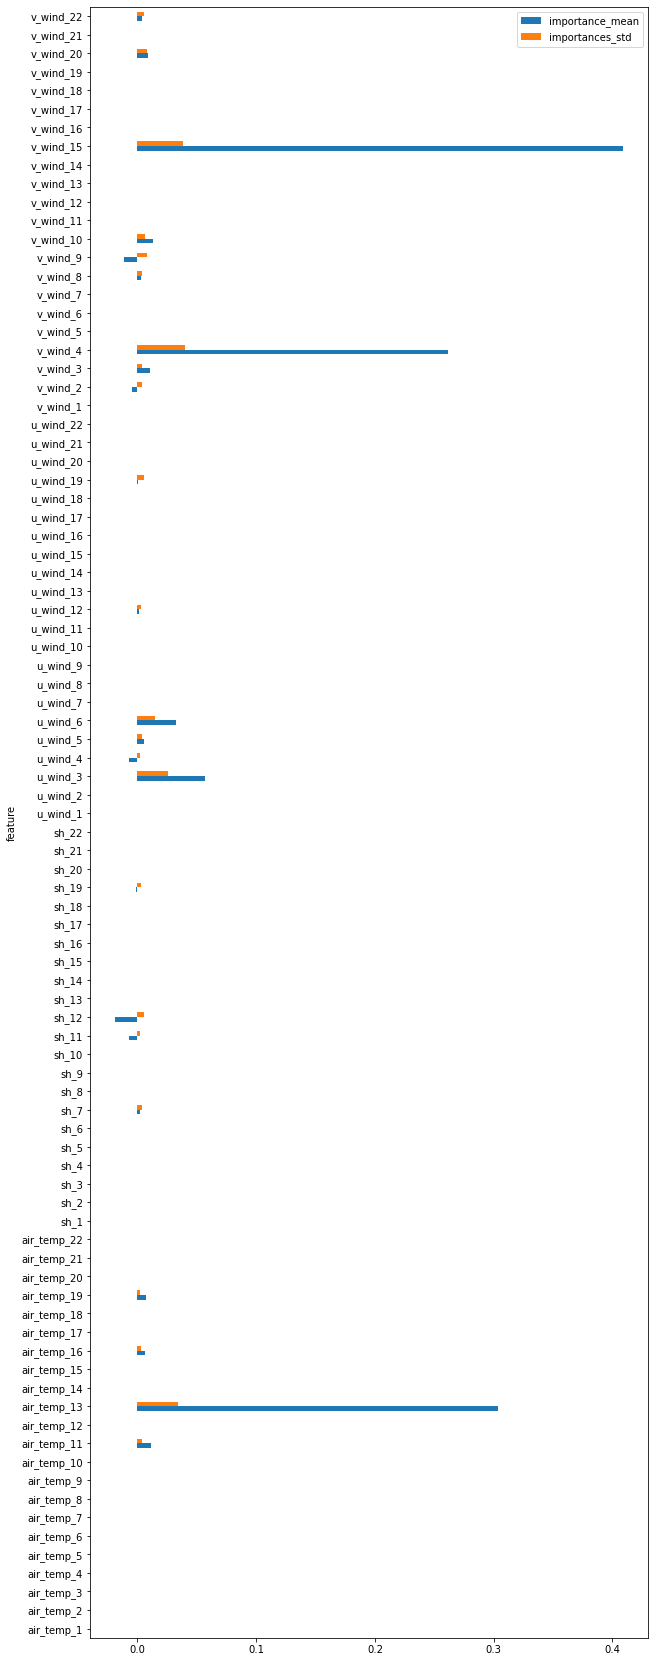

In [45]:
pandas.DataFrame({
    'feature': input_feature_names, 
    'importance_mean':  importances_dict_resampled['importances_mean'],
    'importances_std':  importances_dict_resampled['importances_std'],
}).plot.barh(x='feature',y=['importance_mean', 'importances_std'],figsize=(10,30))

## Examples of use
*UNDER  CONSTRUCTION*


## Next steps

### Reproducible Scalable Machine Learning

Making use of the techniques described here, especially hyperparameter tuning, is very compute intensive and produces a lot of data to keep track of. Two sets of tools from the [MLOps](https://blogs.nvidia.com/blog/2020/09/03/what-is-mlops/) space including parallelisation tools, to run multiple training runs in parallel on a cluster, and experiment tracking or ML lifecycle tools, to keep track of which inputs and hyperparameters correspond to which trained model and the associated metrics and visualisations over the course of the experiment and provide evidence to build trust in subsequent deployment of ML based products.

Scalable ML
* [dask-ml](https://ml.dask.org/)
* [ray](https://www.ray.io/)

Experiment Tracking
* [ML Flow](https://mlflow.org/)

Further information on getting started with these tools to scale up your machine learning experiments can be found in this tutorial:
* [MLOps for Research Software Engineers - UK RSE Conference 2022](https://github.com/informatics-lab/ukrse_2022_mlops_walkthrough)

### Presenting Results

*UNDER  CONSTRUCTION*

Once we've found an experiment setup that produces satisfying results, which have been improved: How can these results be presented? - Should a final "set in stone" experiment be ran, or is a detailed description of the entire experimental process a reasonable solution? 

### Further machine learning overview tutorials
https://github.com/djgagne/ams-ml-python-course

### Interpretable/Explainable Machine Learning - Theory
* https://christophm.github.io/interpretable-ml-book/limo.html
* https://github.com/interpretml/interpret

Interpretable/Explainable Machine Learning - Practical Examples
Colab - What IF Tool (WIT)
* https://pair-code.github.io/what-if-tool/
* https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/WIT_COMPAS_with_SHAP.ipynb#scrollTo=iywHwbJJkeYG
* https://github.com/neomatrix369/awesome-ai-ml-dl/blob/master/data/model-analysis-interpretation-explainability.md


## Dataset Info

### Falklands Rotors Challenge Dataset
Crown Copyright 2021 - This dataset was created by Met Office Chief Operational Meteorologist Steve Ramsdale from Met Office forecast and observation data.
* Model Data - Met Office Global 10km resolution model
* Observations - made by meteorologists at Mount Pleasant airfield in the Falkland Islands.


## References

Hyperparameter search
* [Hyperparameter tuning with scikit-learn - Machine Learning Mastery](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/)
* [scikit-learn docs](https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search)

Data Resampling
* [Imbalanced Learn docs](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiru8rfifT4AhUTQ8AKHWyYAmkQFnoECBQQAQ&url=https%3A%2F%2Fimbalanced-learn.org%2F&usg=AOvVaw1LZ6uQInqba1dPLNkmMvhL)
* [Introduction to SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

Feature Importance
* [Introduction to feature importance for interpretability - Towards Data Science](https://towardsdatascience.com/from-scratch-permutation-feature-importance-for-ml-interpretability-b60f7d5d1fe9)
* [scikit learn feature importance docs](https://scikit-learn.org/stable/modules/permutation_importance.html)

Experiment Tracking
* [ML Flow docs](https://www.mlflow.org/docs/latest/index.html)